<a href="https://colab.research.google.com/github/bforsbe/SK2534/blob/main/kinetics_seminar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Kinetics in Molecular Systems — Seminar Notebook

**Goals (short):**
- Connect thermodynamics (populations) and kinetics (rates).
- Compute rates from energy barriers (Eyring / Arrhenius) and explore temperature dependence.
- Discover how rates combine for **serial** vs **parallel** barriers (students will *derive/discover* the rules).
- Build small kinetic networks (rate matrices) and compute steady states and mean first passage times (MFPT).

This notebook is split into **separate runnable cells** (explanation + code). Each section contains concise derivations and exercises. Run cells in order.



## 1) Boltzmann populations (Thermodynamics refresher)

At equilibrium, the probability (population) of being in microstate $i$ with energy $E_i$
is given by the Boltzmann distribution:
$$
p_i = \frac{e^{-E_i / (k_B T)}}{\sum_j e^{-E_j / (k_B T)}}
$$

- $k_B$ is the Boltzmann constant.
- Use these populations as the thermodynamic *equilibrium* — they **do not** contain time information about dynamic processes like folding or forward and reverse rates.


In [1]:

#@title Compute regular Boltzmann populations
# Compute Boltzmann populations for an example set of energies
import numpy as np

kB = 1.380649e-23  # J/K (for clarity when using J units)
R = 8.314462618  # J/mol/K (useful if energies are in J/mol)
T = 300.0  # K

# Example energies in kJ/mol (convert to J/mol for use with R)
energies_kjmol = np.array([0.0, 5.0, 10.0])  # kJ/mol
energies = energies_kjmol * 1000.0  # J/mol

boltz = np.exp(-energies / (R * T))
probs = boltz / boltz.sum()

print('Energies (kJ/mol):', energies_kjmol)
print('Equilibrium populations:', np.round(probs, 4))


Energies (kJ/mol): [ 0.  5. 10.]
Equilibrium populations: [0.8674 0.1169 0.0157]



## Single barrier

In a previous seminar we derived the metropolis criterion to accept a move to a higher state. We based that on a two-state system where the rates needed to balanace to fulfil the Bolztmann factors. We found that the probablity was
$$k = \exp\left(-\frac{\Delta H}{RT}\right)$$
where $\Delta H$ was the differnece in energy, whereas the probability of going the other way 100%. If we generalize this to many nearby states and all the way to a continuum, it gets very complicated. We have to solve something called the **Fokker–Planck / Smoluchowski equation**, and take it in the limit of **low-temperature / high-barrier limit**, which leads to something called **Karmers classic rate formula**. We don't go into this here, but one neat thing is that this preserves the fundamental form of the expression, and encapsulates aspects about the landscape and other things in a simple frefactor, that we can call $A$. This is the then exactly the Arrhenius equation:

**Arrhenius (simple, empirical):**
$$k = A \cdot \exp\left(-\frac{E_a}{R T}\right)$$
- $A$ is the pre-exponential factor (frequency prefactor).
- $E_a$ is the activation energy (J/mol).



## Arrhenius Plots

An **Arrhenius plot** is a way to test how rates depend on temperature.

We start with the Arrhenius equation:
$$
k = A \, e^{-\frac{E_a}{RT}}
$$

Taking logs:
$$
\ln k = \ln A - \frac{E_a}{R}\frac{1}{T}
$$

If we plot **ln(k)** vs **1/T**, we should see a straight line:
- **Slope:** $-E_a/R$ (gives activation energy $E_a$)  
- **Intercept:** $\ln A$ (gives the prefactor $A$)  

### experiments to measure k

The reaction rate is the change in concentration of reactants or products per unit time, so to measure $k$in practise you need something you can observe and quantify over time, for example:

- Spectroscopy: UV–Vis absorbance, fluorescence, or NMR signals that change with concentration.
- Gas evolution: Measure pressure or volume of gas if the reaction produces/consumes a gas.
- Titration: Quench the reaction at specific times and measure concentration.
- Conductivity or pH: If ionic species are produced/consumed.



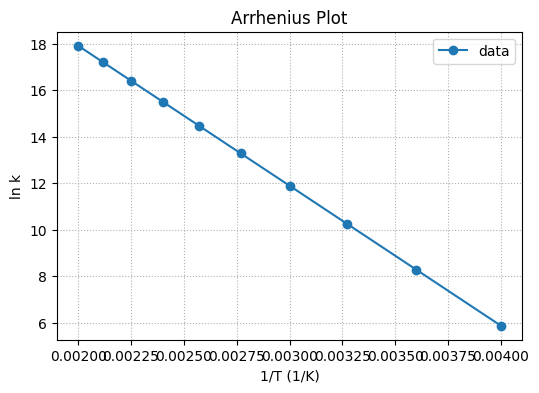

Fitted Ea = 50.00 kJ/mol (true 50.00)


In [8]:
#@title Estimating Ea from synthetic data using an Arrhenius plot
import numpy as np
import matplotlib.pyplot as plt

R = 8.314  # J/mol/K
Ea = 50e3  # activation energy, J/mol
A = 1e13   # pre-exponential factor, 1/s

# Temperature range
T = np.linspace(250, 500, 10)  # Kelvin
k = A * np.exp(-Ea/(R*T))      # rate constants

# Arrhenius plot: ln(k) vs 1/T
plt.figure(figsize=(6,4))
plt.plot(1/T, np.log(k), 'o-', label='data')
plt.xlabel('1/T (1/K)')
plt.ylabel('ln k')
plt.title('Arrhenius Plot')
plt.grid(True, ls=':')
plt.legend()
plt.show()

# Linear regression to extract Ea and A
coeffs = np.polyfit(1/T, np.log(k), 1)
slope, intercept = coeffs
Ea_fit = -slope * R
A_fit = np.exp(intercept)

print(f"Fitted Ea = {Ea_fit/1000:.2f} kJ/mol (true {Ea/1000:.2f})")
#print(f"Fitted A  = {A_fit:.2e} 1/s (true {A:.2e})")


## Serial barriers (A → I → B)

But a single transtion state seems crazy - protein folding must be a very complicated process, not just a two-state hop. Let's see what happens if we add just one more hop, going to an intermediate state $I$ before getting from $A$ to $B$:

If $A$→$I$ occurs with rate $k_1$ and $I$→$B$ with rate $k_2$ (no branching or backflow), then the **expected time** to go from $A$ to $B$ is the sum of expected times for the two steps:
$$
\tau = \frac{1}{k_1} + \frac{1}{k_2}.
$$
Thus the **effective rate** (one over the mean time) is
$$
k_{\mathrm{eff}} = \frac{1}{\tau} = \frac{1}{\frac{1}{k_1} + \frac{1}{k_2}} = \frac{k_1 k_2}{k_1 + k_2}.
$$

**Caveat:** This is an approximation under certain assumptions, but to first approximation accurate. This expression is clearly dominated by the **slower** rate, corresponding to the higher barrier. The only time that is not the case is when multiple barriers are close in energy, but even then the most important thing to remember still applies; we can think of an effective rate and barrier. This generalizes, so that we can always think of it as such, no matter how many barriers.

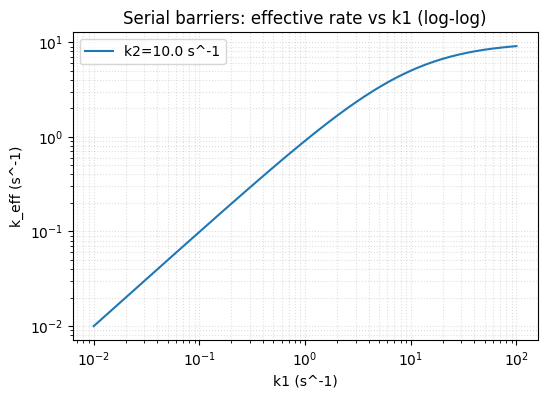

k1=  0.01, k2= 10.00 => k_eff=0.0100 s^-1
k1=  0.10, k2= 10.00 => k_eff=0.0990 s^-1
k1=  1.00, k2= 10.00 => k_eff=0.9091 s^-1
k1= 10.00, k2= 10.00 => k_eff=5.0000 s^-1
k1=100.00, k2= 10.00 => k_eff=9.0909 s^-1


In [4]:

#@title  Serial barriers: numerical exploration
import numpy as np
import matplotlib.pyplot as plt

def serial_keff(k1, k2):
    tau = 1.0/k1 + 1.0/k2
    return 1.0/tau

k2 = 10.0  # s^-1 (fixed)
ks = np.logspace(-2, 2, 200)  # sweep k1
keff_serial = [serial_keff(k1, k2) for k1 in ks]

plt.figure(figsize=(6,4))
plt.loglog(ks, keff_serial, label=f'k2={k2} s^-1')
plt.xlabel('k1 (s^-1)')
plt.ylabel('k_eff (s^-1)')
plt.title('Serial barriers: effective rate vs k1 (log-log)')
plt.grid(True, which='both', ls=':', alpha=0.4)
plt.legend()
plt.show()

# Print a couple of values to show limiting behavior
for k1 in [0.01, 0.1, 1.0, 10.0, 100.0]:
    print(f'k1={k1:6.2f}, k2={k2:6.2f} => k_eff={serial_keff(k1,k2):.4f} s^-1')


## Parallel barriers (competing pathways)

If A can go to B via two independent channels with rates \(k_1\) and \(k_2\), the time to leave A
and reach B is the minimum of two independent exponential waiting times. The minimum of independent exponentials
is exponential with rate equal to the sum of the rates, hence:
$$
k_{\mathrm{eff}} = k_1 + k_2.
$$

**Branching ratio:** the fraction of transitions taking path 1 is
$$
P(\text{path 1}) = \frac{k_1}{k_1 + k_2},
$$
and similarly for path 2. This means that we effectivley lower the barrier by having two options! Not too surprising perhaps, but again, the important part is that we can think of an effective rate even in the prescence of multiple parallel pathways to go from $A$to $B$, as in the folded-unfolded transtion.



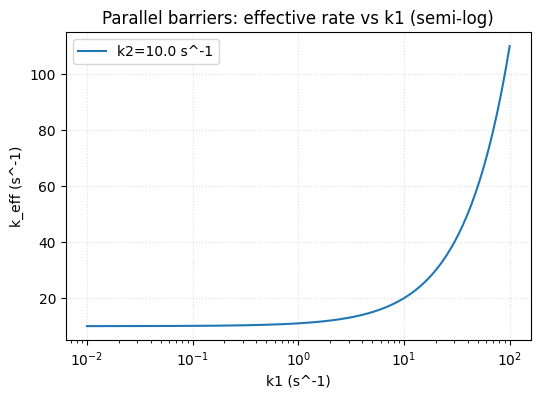

k1=  0.01, k2= 10.00 => k_eff=10.0100 s^-1, frac path1=0.001
k1=  0.10, k2= 10.00 => k_eff=10.1000 s^-1, frac path1=0.010
k1=  1.00, k2= 10.00 => k_eff=11.0000 s^-1, frac path1=0.091
k1= 10.00, k2= 10.00 => k_eff=20.0000 s^-1, frac path1=0.500
k1=100.00, k2= 10.00 => k_eff=110.0000 s^-1, frac path1=0.909


In [5]:

#@title Parallel barriers: numerical exploration
import numpy as np
import matplotlib.pyplot as plt

def parallel_keff(k1, k2):
    return k1 + k2

k2 = 10.0  # s^-1 fixed
ks = np.logspace(-2, 2, 200)
keff_parallel = [parallel_keff(k1, k2) for k1 in ks]

plt.figure(figsize=(6,4))
plt.semilogx(ks, keff_parallel, label=f'k2={k2} s^-1')
plt.xlabel('k1 (s^-1)')
plt.ylabel('k_eff (s^-1)')
plt.title('Parallel barriers: effective rate vs k1 (semi-log)')
plt.grid(True, ls=':', alpha=0.4)
plt.legend()
plt.show()

# branching fraction examples
for k1 in [0.01, 0.1, 1.0, 10.0, 100.0]:
    frac1 = k1 / (k1 + k2)
    print(f'k1={k1:6.2f}, k2={k2:6.2f} => k_eff={parallel_keff(k1,k2):.4f} s^-1, frac path1={frac1:.3f}')
